<a href="https://colab.research.google.com/github/adilkureshi/Toxic-Comments-Detection/blob/main/comments_toxicity_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Embedding, Input, Dense,\
    GlobalMaxPooling1D, LSTM, Bidirectional
from sklearn.metrics import roc_auc_score

### Configurations

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
EMBEDDING_DIMENSION = 100
EMBEDDING_FILE_LOC = '/content/drive/My Drive/cp/100.txt'
TRAINING_DATA_LOC = '/content/drive/My Drive/cp/CP/data/train.csv'
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

Mounted at /content/drive


### Data Preprocessing Steps


#### Import the Pre-Trained Word Vectors
(Link - http://nlp.stanford.edu/data/glove.6B.zip)

In [3]:
word_to_vector = {}
with open(EMBEDDING_FILE_LOC) as file:
    # A space-separated text file in the format
    # word vec[0] vec[1] vec[2] ...
    for line in file:
        word = line.split()[0]
        word_vec = line.split()[1:]

        # converting word_vec into numpy array
        # adding it in the word_to_vector dictionary
        word_to_vector[word] = np.asarray(word_vec, dtype='float32')

    # print the total words found
    print(f'Total of {len(word_to_vector)} word vectors are found.')

Total of 400001 word vectors are found.


#### Import Training Data

In [4]:
training_data = pd.read_csv(TRAINING_DATA_LOC)

#### Explore Training Data

In [5]:
training_data.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0


In [6]:
# Checking the data info for any null entries present
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


#### Split Data into Feature (Comment) and Target Classes

In [7]:
comments = training_data['comment_text'].values
detection_classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
target_classes = training_data[detection_classes].values

#### Length Information of Comments

In [8]:
# Max and Min Length
print(f'Maximum length of the comments {max(len(s) for s in comments)}')
print(f'Minimum length of the comments {min(len(s) for s in comments)}')

# Median Length
s = sorted(len(s) for s in comments)
print(f'Median length of the comments {s[len(s) // 2]}')

Maximum length of the comments 5000
Minimum length of the comments 6
Median length of the comments 205


#### Convert Comments (Strings) into Integers

In [9]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(comments)
sequences = tokenizer.texts_to_sequences(comments)

#### Word to Integer Mapping

In [10]:
word_to_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_to_index))

Found 210337 unique tokens.


#### Padding Sequences to a N x T Matrix

In [11]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (159571, 100)


#### Form the embedding matrix

##### Preparation of Embedding Matrix

In [12]:
num_words = min(MAX_VOCAB_SIZE, len(word_to_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSION))
for word, i in word_to_index.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word_to_vector.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros
      embedding_matrix[i] = embedding_vector

##### Load Pre-Trained Word Embeddings into an Embedding Layer

In [13]:
# Set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIMENSION,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

#### Build the Bidirectional LSTM Model

In [14]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Bidirectional(LSTM(units=15, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
output = Dense(len(detection_classes), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 30)          13920     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 186       
                                                                 
Total params: 2,014,106
Trainable params: 14,106
Non-trainabl

#### Train the Bidirectional LSTM model

In [16]:
rnn_model = model.fit(data,
                      target_classes,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_split=VALIDATION_SPLIT)

Epoch 1/10
998/998 [==============================] - 100s 96ms/step - loss: 0.1133 - accuracy: 0.8893 - val_loss: 0.0680 - val_accuracy: 0.9936
Epoch 2/10
998/998 [==============================] - 97s 97ms/step - loss: 0.0625 - accuracy: 0.9932 - val_loss: 0.0601 - val_accuracy: 0.9940
Epoch 3/10
998/998 [==============================] - 94s 94ms/step - loss: 0.0571 - accuracy: 0.9940 - val_loss: 0.0573 - val_accuracy: 0.9940
Epoch 4/10
998/998 [==============================] - 95s 95ms/step - loss: 0.0545 - accuracy: 0.9936 - val_loss: 0.0557 - val_accuracy: 0.9930
Epoch 5/10
998/998 [==============================] - 95s 95ms/step - loss: 0.0527 - accuracy: 0.9923 - val_loss: 0.0540 - val_accuracy: 0.9918
Epoch 6/10
998/998 [==============================] - 95s 95ms/step - loss: 0.0512 - accuracy: 0.9903 - val_loss: 0.0532 - val_accuracy: 0.9878
Epoch 7/10
998/998 [==============================] - 93s 93ms/step - loss: 0.0500 - accuracy: 0.9865 - val_loss: 0.0520 - val_accuracy

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 100, 30)          13920     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 6)                 186       
                                                                 
Total params: 2,014,106
Trainable params: 14,106
Non-trainabl

#### Model Evaluation

##### Plot the training and validation loss

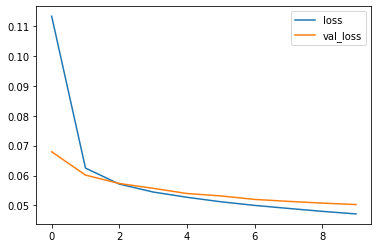

In [18]:
plt.plot(rnn_model.history['loss'], label='loss')
plt.plot(rnn_model.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

##### Plot the training and validation loss

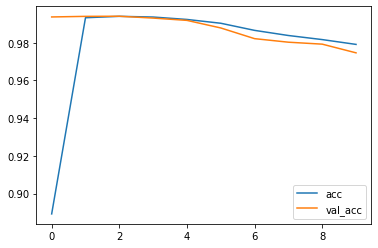

In [19]:
plt.plot(rnn_model.history['accuracy'], label='acc')
plt.plot(rnn_model.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

##### Average ROC_AUC Score

In [20]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(target_classes[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.9808774225149137


In [21]:
#Configurations
EMBEDDING_DIMENSION = 100
EMBEDDING_FILE_LOC = '../model/glove/glove.6B.' + str(EMBEDDING_DIMENSION) + 'd.txt'
TRAINING_DATA_LOC = '../data/train.csv'
TEST_DATA_LABEL = '../data/test_labels.csv'
TEST_DATA_COMMENTS = '../data/test.csv'
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
BATCH_SIZE = 128
EPOCHS = 30
VALIDATION_SPLIT = 0.2
DETECTION_CLASSES = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate',
    'neutral']
MODEL_LOC = '/content/drive/My Drive/cp/comments_toxicity.h5'
TOKENIZER_LOC = '/content/drive/My Drive/cp/tokenizer.pickle'

In [22]:
import nltk
import re
import spacy
from nltk.corpus import stopwords
from textblob import TextBlob

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nltk.download('stopwords')
stop_words = stopwords.words('english')


#Data Cleaning

def convert_to_lower_case(text):
    """
    Coverts the specified text to lower case
    :param text: the text to convert
    :return: the lower cased text
    """
    return " ".join(text.lower() for text in text.split())


def apply_contraction_mapping(text):
    """
    Applies the contraction mapping to the specified text
    :param text: the text on which the contraction will be mapped
    :return: the text after the application of contraction mapping
    """
    contraction_mapping = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                           "could've": "could have", "couldn't": "could not",
                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
                           "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will",
                           "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                           "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                           "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am",
                           "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have",
                           "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
                           "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
                           "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                           "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                           "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                           "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                           "she'll've": "she will have", "she's": "she is", "should've": "should have",
                           "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                           "so's": "so as",
                           "this's": "this is", "that'd": "that would", "that'd've": "that would have",
                           "that's": "that is",
                           "there'd": "there would", "there'd've": "there would have", "there's": "there is",
                           "here's": "here is",
                           "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
                           "they'll've": "they will have",
                           "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                           "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
                           "we'll've": "we will have",
                           "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                           "what'll've": "what will have",
                           "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
                           "when've": "when have",
                           "where'd": "where did", "where's": "where is", "where've": "where have",
                           "who'll": "who will",
                           "who'll've": "who will have",
                           "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have",
                           "will've": "will have",
                           "won't": "will not", "won't've": "will not have", "would've": "would have",
                           "wouldn't": "would not",
                           "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                           "y'all'd've": "you all would have",
                           "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would",
                           "you'd've": "you would have", "you'll": "you will",
                           "you'll've": "you will have", "you're": "you are", "you've": "you have"}
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text


def fix_misspelled_words2(text):
    """
    Fixes the misspelled words on the specified text (uses predefined misspelled dictionary)
    :param text: The text to be fixed
    :return: the fixed text
    """
    mispelled_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling',
                      'counselling': 'counseling',
                      'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                      'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora',
                      'sallary': 'salary',
                      'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                      'howcan': 'how can',
                      'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I',
                      'theBest': 'the best',
                      'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate',
                      "mastrubating": 'masturbating',
                      'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data',
                      '2k17': '2017', '2k18': '2018',
                      'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                      'watsapp': 'whatsapp',
                      'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                      'demonetisation': 'demonetization', ' ur ': 'your', ' u r ': 'you are'}
    for word in mispelled_dict.keys():
        text = text.replace(word, mispelled_dict[word])
    return text


def fix_misspelled_words(text):
    """
    Fixes the misspelled words on the specified text (uses TextBlob model)
    :param text: The text to be fixed
    :return: the fixed text
    """
    b = TextBlob(text)
    return str(b.correct())


def remove_punctuations(text):
    """
    Removes all punctuations from the specified text
    :param text: the text whose punctuations to be removed
    :return: the text after removing the punctuations
    """
    return text.replace(r'[^\w\s]', '')


def remove_emojis(text):
    """
    Removes emojis from the specified text
    :param text: the text whose emojis need to be removed
    :return: the text after removing the emojis
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_stopwords(text):
    """
    Removes all stop words from the specified text
    :param text: the text whose stop words need to be removed
    :return: the text after removing the stop words
    """
    return " ".join(x for x in text.split() if x not in stop_words)


def lemmatise(text):
    """
    Lemmatises the specified text
    :param text: the text which needs to be lemmatised
    :return: the lemmatised text
    """
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])


def clean_text_column(text_column):
    """
    Cleans the text specified in the text column
    The cleaning procedure is as follows:
    1. Convert the context to lower case
    2. Apply contraction mapping in which we fix shorter usages of english sentences
    3. Fix misspelled words
    4. Remove all punctuations
    5. Remove all emojis
    6. Remove all stop words
    7. Apply Lemmatisation
    :param text_column: the text column which needs to be cleaned
    :return: the text column with the cleaned data
    """
    return text_column.apply(lambda x: clean_text(x))


def clean_text(text):
    """
    Cleans the specified text
    The cleaning procedure is as follows:
    1. Convert the context to lower case
    2. Apply contraction mapping in which we fix shorter usages of english sentences
    3. Fix misspelled words
    4. Remove all punctuations
    5. Remove all emojis
    6. Remove all stop words
    7. Apply Lemmatisation
    :param text: the text which needs to be cleaned
    :return: the cleaned text
    """
    text = convert_to_lower_case(text)
    text = apply_contraction_mapping(text)
    text = fix_misspelled_words2(text)
    text = remove_punctuations(text)
    text = remove_emojis(text)
    text = remove_stopwords(text)
    text = lemmatise(text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 24.3 MB/s 
     |████████████████████████████████| 275 kB 72.6 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 54 kB 3.8 MB/s 
     |████████████████████████████████| 212 kB 78.5 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
     |████████████████████████████████| 112 kB 77.5 MB/s 
     |████████████████████████████████| 2.3 MB 64.5 MB/s 
     |████████████████████████████████| 54 kB 4.2 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 10.5 MB/s 
     |████████████████████████████████| 68 kB 5.9 MB/s 
     |████████████████████████████████| 43 kB 2.7 MB/s 
     |████████████████████████████████| 62 kB 940 kB/s 
     |████████████████████████████████| 4.1 MB 56.

In [25]:
import pickle

import gradio as gr
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

# Load Existing Model and Tokenizer
# load the trained model
rnn_model = load_model(MODEL_LOC)

# load the tokenizer
with open(TOKENIZER_LOC, 'rb') as handle:
    tokenizer = pickle.load(handle)


#Main Application

def make_prediction(input_comment):
    """
    Predicts the toxicity of the specified comment
    :param input_comment: the comment to be verified
    """
    input_comment = clean_text(input_comment)
    input_comment = input_comment.split(" ")

    sequences = tokenizer.texts_to_sequences(input_comment)
    sequences = [[item for sublist in sequences for item in sublist]]

    padded_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    result = rnn_model.predict(padded_data, len(padded_data), verbose=1)

    return \
        {
            "Toxic": str(result[0][0]),
            "Very Toxic": str(result[0][1]),
            "Obscene": str(result[0][2]),
            "Threat": str(result[0][3]),
            "Insult": str(result[0][4]),
            "Hate": str(result[0][5]),
            "Neutral": str(result[0][6])
        }


comment = gr.inputs.Textbox(lines=17, placeholder="Enter your comment here")

title = "Comments Toxicity Detection"
description = "Please Insert Comment"

gr.Interface(fn=make_prediction,
             inputs=comment,
             outputs="label",
             title=title,
             description=description) \
    .launch()

/usr/local/lib/python3.7/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  "Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components",
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10243.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7ff1b31e3650>,
 'http://127.0.0.1:7861/',
 'https://10243.gradio.app')